In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import dump
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

In [3]:
import Py_FTP_Langevin as ftp
import ftp_support

In [4]:
k_B = 1.38066e-23    #! Boltzmann constant in (J/K)
Na = 6.02214076 * pow(10,23) # 1/mol

In [5]:
fontsize_axis = 20
fontsize_legend = 16
fontsize_ticks = 14

# First time passage simulations

In [6]:
#//! *********** PARAMETERS PARTICLE PROPERTIES *********** !
MM,Rho_p,epsilon_lj,sigma_lj,A = ftp.support.Get_params_particles("Ag")

#//! *********** SIMULATION PARAMETERS *********** !
N_runs = 100 #;
Box_L_factor_dmax = 50. #4 #; //! Box size as factor of D_p
T_g = 1700. #;            //! Fluid temperature
P_g = 101300. #;          //! Fluid pressure
phi_p = 0.01 / 100 #;   //! Particles number concentration (1000 ppm = 0.01)    
with_collisions = True
with_rel_motion = True
with_rotation = False

#//! *********** LANGEVIN PARAMETERS *********** !
run_taus_min = 120 #; // Keep in 100 to be accurate with LD theory (otherwise the 6*D*t is not strictly respected)
LD_dt_factor = 1e-03 #;

#//! *********** PARAMETERS INT. POTENTIALS *********** !
alpha_dp = 0.01
factor_vdw = 1.05
direct = "/home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/Simulations/aggregate_info";

In [8]:
model = ftp.Pymodel(direct)
model

In [9]:
Dp = np.logspace(np.log10(1),np.log10(1e+03),10) * (1e-09)
#Dp = np.logspace(np.log10(1),np.log10(1e+03),100) * (1e-09)

In [10]:
# Potential well analysis
e_well_i = np.zeros_like(Dp)
r_e_well_i = np.zeros_like(Dp)
factor_vdw_i = np.zeros_like(Dp)

k_BT = k_B * T_g

for i in range(len(Dp)):
    e_well,r_e_well = ftp_support.Determine_pot_well(Dp[i],Dp[i],A,sigma_lj,k_BT)
    e_well_i[i] = e_well
    r_e_well_i[i] = r_e_well
    factor_vdw_i[i] = 1+r_e_well/(0.5*(Dp[i]+Dp[i]))

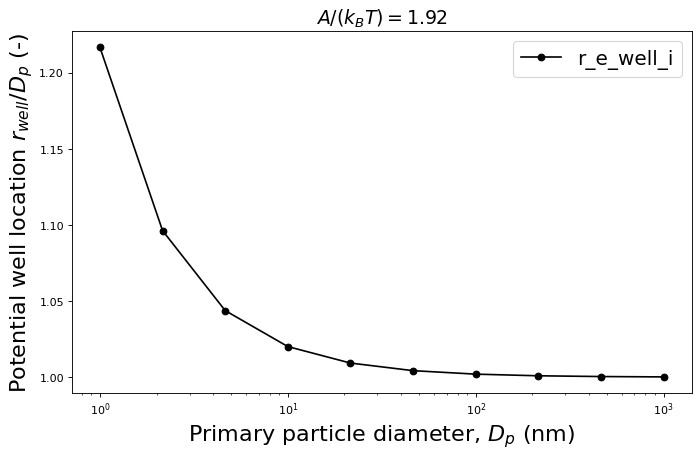

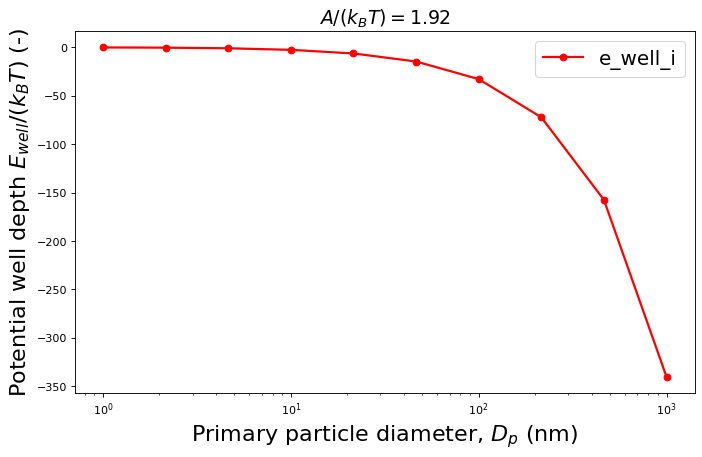

(<matplotlib.legend.Legend at 0x7f4d9325aaf0>, None)

In [11]:
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(Dp*1e+09,r_e_well_i/Dp,"o-k",label="r_e_well_i")
title = "$A/(k_BT)=$"+str(round(A/(k_B*T_g),2))
plt.title(title,fontsize=17); plt.xscale("log")
ax1.set_ylabel('Potential well location $r_{well}/D_p$ (-)', fontsize=20)
ax1.set_xlabel('Primary particle diameter, $D_p$ (nm)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(Dp*1e+09,e_well_i,"o-r", linewidth=2,label="e_well_i")
#ax1.plot(Dp*1e+09,r_e_well_i/Dp,".-k",label="r_e_well_i")
title = "$A/(k_BT)=$"+str(round(A/(k_B*T_g),2))
plt.title(title,fontsize=17); plt.xscale("log")
ax1.set_ylabel('Potential well depth $E_{well}/(k_BT)$ (-)', fontsize=20)
ax1.set_xlabel('Primary particle diameter, $D_p$ (nm)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

In [12]:
ftp.Init_Random()
ftp.Make_output_folder()

In [13]:
files = ftp.get_dir_files(direct)
N_files = len(files)

In [14]:
def isNaN(num):
    if float('-inf') < float(num) < float('inf'):
        return False 
    else:
        return True

In [15]:
factor_vdw = r_e_well_i[0]/Dp[0]
model.Set_prop(MM,Rho_p,N_runs,Box_L_factor_dmax,
               T_g,P_g,phi_p,run_taus_min,LD_dt_factor,
               A,sigma_lj,alpha_dp,factor_vdw,Dp[0],
               with_collisions,with_rel_motion,with_rotation,direct)

ftp_model = ftp.PyFTP(model)

path_agg = direct + "/" + files[0].decode('utf-8')
print(path_agg)

/home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/Simulations/aggregate_info/Agglomerate_N_000000001_Agg_00000001.dat


In [16]:
ftp_times_j = np.zeros(len(Dp))
ftp_times_std_j = np.zeros(len(Dp))
Kn_d_j = np.zeros(len(Dp))
Kn_g_j = np.zeros(len(Dp))
tau_12_j = np.zeros(len(Dp))
L_j = np.zeros(len(Dp))
Rc_j = np.zeros(len(Dp))

In [17]:
for j in tqdm(range(len(Dp))):
    print("Analysis: ",j)
    factor_vdw = r_e_well_i[j]/Dp[j]
    model.Set_prop(MM,Rho_p,N_runs,Box_L_factor_dmax,
               T_g,P_g,phi_p,run_taus_min,LD_dt_factor,
               A,sigma_lj,alpha_dp,factor_vdw,Dp[j],
               with_collisions,with_rel_motion,with_rotation,direct)
    ftp_model.Load_aggregates_external(path_agg, model)
    ftp_times = np.asarray([])
    
    for k in range(N_runs):
        ftp_model.Restart_ftp(model)
        #ftp_model.show_spheres()
        #if (k == 0):
        #    ftp.Show_parameters(spheres2, model)
        ftp_model.Move_2_origin()
        ftp_model.Random_init_location()
        #Export_current_sim(ftp_model,0,True)
        i=1
        it_exp = 1
        collision = False
        while(not collision):
            collision = ftp_model.run(model, 1)
            if(isNaN(ftp_model.t_res)):
                print("d_time ",ftp_model.d_time, " t_res ",ftp_model.t_res)
                break
        i += 1
        ftp_times = np.append(ftp_times, ftp_model.t_res)
    ftp_times_std_j[j] = np.std(ftp_times)
    ftp_times_j[j] = np.mean(ftp_times)
    tau_12_j[j] = ftp_model.Tau_ij
    Kn_d_j[j] = ftp_model.Kn_d_ij
    Kn_g_j[j] = ftp_model.Kn_g_avg
    L_j[j] = ftp_model.L_box
    Rc_j[j] = ftp_model.Rc

  0%|                                                                                         | 0/10 [00:00<?, ?it/s]

Analysis:  0


 10%|████████                                                                        | 1/10 [03:44<33:44, 224.91s/it]

Analysis:  1


 20%|████████████████                                                                | 2/10 [08:09<33:06, 248.34s/it]

Analysis:  2


 30%|████████████████████████                                                        | 3/10 [12:13<28:44, 246.43s/it]

Analysis:  3


 40%|████████████████████████████████                                                | 4/10 [16:28<24:58, 249.83s/it]

Analysis:  4


 50%|████████████████████████████████████████                                        | 5/10 [20:46<21:02, 252.47s/it]

Analysis:  5


 60%|████████████████████████████████████████████████                                | 6/10 [25:51<18:01, 270.41s/it]

Analysis:  6


 70%|████████████████████████████████████████████████████████                        | 7/10 [31:28<14:36, 292.30s/it]

Analysis:  7


 80%|████████████████████████████████████████████████████████████████                | 8/10 [42:47<13:51, 415.51s/it]

Analysis:  8


 90%|██████████████████████████████████████████████████████████████████████▏       | 9/10 [1:07:52<12:36, 756.09s/it]

Analysis:  9


100%|█████████████████████████████████████████████████████████████████████████████| 10/10 [2:32:15<00:00, 913.59s/it]


In [18]:
# Box size
V_box = np.power(L_j,3)

t_ij = ftp_times_j/tau_12_j

H = V_box/(np.power(Rc_j,3)*t_ij)

In [19]:
def H_function(Kn_d2):
    cc1 = 25.836
    cc2 = 11.211
    cc3 = 3.502
    cc4 = 7.211
    H_gop = (4.0*np.pi*pow(Kn_d2,2)+cc1*pow(Kn_d2,3)+
        np.sqrt(8.0*np.pi)*cc2*pow(Kn_d2,4))/(1.0+cc3*Kn_d2+
        cc4*pow(Kn_d2,2)+cc2*pow(Kn_d2,3))
    return H_gop

def H_diffusive(Kn_d2):
    H_d = 4*np.pi*pow(Kn_d2,2)
    return H_d

def H_ballistic(Kn_d2):
    H_b = np.sqrt(8*np.pi)*Kn_d2
    return H_b

In [20]:
Kn_d2 = np.logspace(np.log10(1e-02),np.log10(8e+02), 500)
H_theo = H_function(Kn_d2)

H_theo_d = H_diffusive(Kn_d2)
H_theo_b = H_ballistic(Kn_d2)

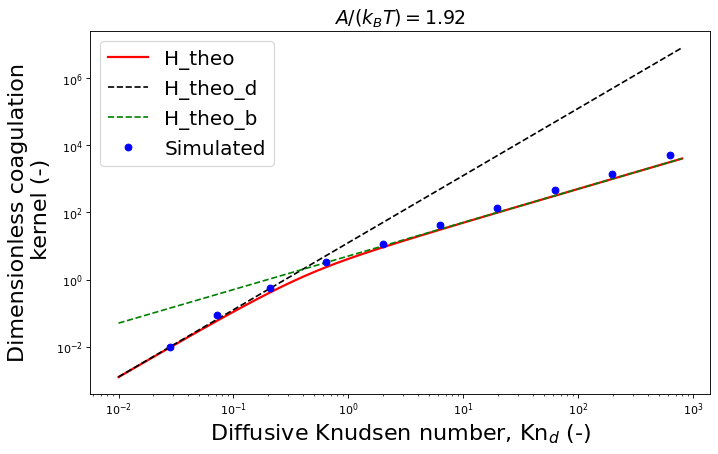

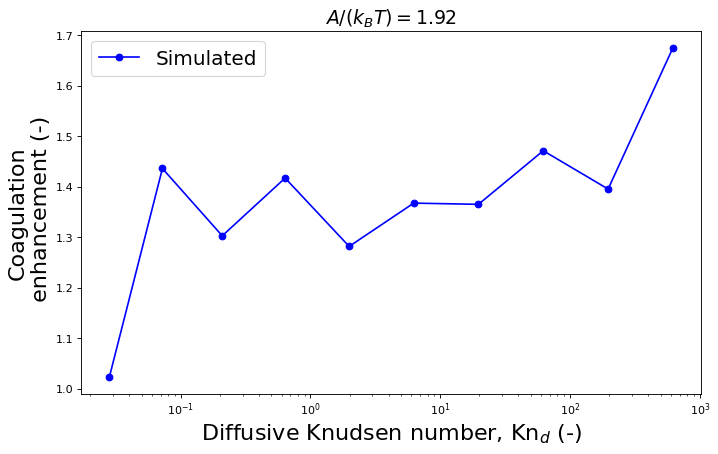

(<matplotlib.legend.Legend at 0x7f4d91a8fdf0>, None)

In [25]:
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.loglog(Kn_d2,H_theo,"-r", linewidth=2,label="H_theo")
ax1.loglog(Kn_d2,H_theo_d,"--k",label="H_theo_d")
ax1.loglog(Kn_d2,H_theo_b,"--g",label="H_theo_b")
ax1.loglog(Kn_d_j,H,"o b",label="Simulated")
title = "$A/(k_BT)=$"+str(round(A/(k_B*T_g),2))
plt.title(title,fontsize=17)
ax1.set_xlabel('Diffusive Knudsen number, Kn$_d$ (-)', fontsize=20)
ax1.set_ylabel('Dimensionless coagulation\n kernel (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

H_theo_j = H_function(Kn_d_j)

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(Kn_d_j,H/H_theo_j,"o-b",label="Simulated")
title = "$A/(k_BT)=$"+str(round(A/(k_B*T_g),2))
plt.title(title,fontsize=17)
plt.xscale("log")
ax1.set_xlabel('Diffusive Knudsen number, Kn$_d$ (-)', fontsize=20)
ax1.set_ylabel('Coagulation\n enhancement (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

In [26]:
results_exp = np.column_stack((Kn_d_j,H,ftp_times_j,ftp_times_std_j,tau_12_j,Kn_g_j,
                              L_j,Rc_j,V_box,t_ij))

file_name = "data_out/validation_spheres_with_vdw_Cu.dat"
np.savetxt(file_name, results_exp, delimiter=",")